# Tensorflow tutorial

In [89]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tensorflow.keras import losses
import re
import string
import keras
import matplotlib.pyplot as plt

## Set random state

In [59]:
seed = 42
np.random.seed(42)
tf.random.set_seed(seed)

## Load data

In [60]:
data_dir = "./data/aclImdb"

In [61]:
raw_training_set = tf.keras.utils.text_dataset_from_directory(
    f"{data_dir}/train",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

raw_validation_set = tf.keras.utils.text_dataset_from_directory(
    f"{data_dir}/train",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

raw_test_set = tf.keras.utils.text_dataset_from_directory(
    f"{data_dir}/test",
    labels="inferred",
    label_mode="int",
    batch_size=32,
)

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Found 5000 files belonging to 2 classes.


In [62]:
raw_training_set.class_names[0]

'neg'

In [63]:
raw_training_set.class_names[1]

'pos'

## Process / take 1 batch

In [64]:
for text_batch, label_batch in raw_training_set.take(1):
    for i in range(3):
        print(f"Review:\n {text_batch.numpy()[i]}")
        print(f"Label: {label_batch.numpy()[i]}")
        print()

Review:
 b'This is a reunion, a team, and a great episode of Justice. From hesitation to resolution, Clark has made a important leap from a troubled teenager who was afraid of a controlled destiny, to a Superman who, like Green Arrow, sets aside his emotions to his few loved ones, ready to save the whole planet. This is not just a thrilling story about teamwork, loyalty, and friendship; this is also about deciding what\'s more important in life, a lesson for Clark. I do not want the series to end, but I hope the ensuing episodes will strictly stick to what Justice shows without any "rewind" pushes and put a good end here of Smallville---and a wonderful beginning of Superman.<br /><br />In this episode, however, we should have seen more contrast between Lex and the Team. Nine stars should give it enough credit.'
Label: 1

Review:
 b'"Hey Babu Riba" is a film about a young woman, Mariana (nicknamed "Esther" after a famous American movie star), and four young men, Glenn, Sacha, Kicha, and

2024-04-11 17:46:05.820649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Prepare data

In [65]:
# Set the maximum number of words (most common tokens)
max_features = 10000


def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    replaced = tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )
    return replaced

In [66]:
# Create a layer that you can use to convert text to vectors

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=250,
)

In [67]:
train_text = raw_training_set.map(lambda x, y: x)

In [68]:
vectorize_layer.adapt(train_text)

2024-04-11 17:46:06.437780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [69]:
print(f"Vocabulary size: {len(vectorize_layer.get_vocabulary())}")

Vocabulary size: 10000


In [70]:
def vectorize_text(text, label):
    # Think just makes a [N] shapes vector to a [N, 1] shaped vector
    # No, it makes it from one string to a [string]
    # print(f"Shape text: {text.shape}")
    text = tf.expand_dims(text, -1)
    # print(f"Text: {text}")
    # print(f"Shape text: {text.shape}")
    return vectorize_layer(text), label

In [71]:
text_batch, label_batch = next(iter(raw_training_set))
first_review, first_label = text_batch[0], label_batch[0]

print(f"Review:\n{first_review}")
print(f"\nLabel: {raw_training_set.class_names[first_label]}")
print(f"\nVectorized review\n{vectorize_text(first_review, first_label)}")

Review:
b"This movie is about a side of Ireland that Americans don't normally see, the narrow-minded religiously prejudiced side of the 'friendliest race in the world'. The movie, by the admission of the inhabitants of Fethard who are old enough to remember the events, is fairly accurate (though they insist that the film-makers invented some of the more violent scenes just to spice up the action).<br /><br />The movie was very unpopular in Ireland as it portrayed the Catholic church in a bad light, but the simple fact is that representatives of the Catholic church *did* organise vetoes of minorities (before Protestants it was the Jews).<br /><br />The film is a fascinating insight into the whole issue of religion in Ireland"

Label: pos

Vectorized review
(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  10,   17,    7,   42,    3,  421,    5, 2801,   12, 1931,   87,
        1709,   65,    2,    1,    1,    1,  421,    5,    2,    1, 1487,
           8,    2,  185,    2,   17,

In [72]:
train_ds = raw_training_set.map(vectorize_text)
val_ds = raw_validation_set.map(vectorize_text)
test_ds = raw_test_set.map(vectorize_text)

In [73]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [74]:
embedding_dim = 16

# Create the model by calling tf.keras.Sequential, where the layers are given in a list.
model_sequential = tf.keras.Sequential(
    [
        layers.Embedding(max_features, embedding_dim),
        layers.GlobalAveragePooling1D(),
        layers.Dense(1, activation="sigmoid"),
    ]
)

In [75]:
model_sequential.compile(
    loss=losses.BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"]
)
# Print out the summary of the model
model_sequential.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [76]:
# Define the inputs
inputs = tf.keras.Input(shape=(None,))

# Define the first layer
embedding = layers.Embedding(max_features, embedding_dim)
# Call the first layer with inputs as the parameter
x = embedding(inputs)

# Define the second layer
pooling = layers.GlobalAveragePooling1D()
# Call the first layer with the output of the previous layer as the parameter
x = pooling(x)

# Define and call in the same line. (Same thing used two lines of code above
# for other layers. You can use any option you prefer.)
outputs = layers.Dense(1, activation="sigmoid")(x)
# The two-line alternative to the one layer would be:
# dense = layers.Dense(1, activation='sigmoid')
# x = dense(x)


# Create the model
model_functional = tf.keras.Model(inputs=inputs, outputs=outputs)

# Print out the summary of the model
model_functional.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, None, 16)       │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,017 (625.07 KB)

 Trainable params: 160,017 (625.07 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
model_functional.compile(
    loss=losses.BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"]
)

In [78]:
model = model_functional

In [79]:
epochs = 25
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=2)

Epoch 1/25
125/125 - 1s - 5ms/step - accuracy: 0.5490 - loss: 0.6902 - val_accuracy: 0.5830 - val_loss: 0.6852
Epoch 2/25
125/125 - 0s - 2ms/step - accuracy: 0.6190 - loss: 0.6786 - val_accuracy: 0.6420 - val_loss: 0.6717
Epoch 3/25
125/125 - 0s - 2ms/step - accuracy: 0.6805 - loss: 0.6594 - val_accuracy: 0.6940 - val_loss: 0.6494
Epoch 4/25
125/125 - 0s - 2ms/step - accuracy: 0.7205 - loss: 0.6307 - val_accuracy: 0.7120 - val_loss: 0.6213
Epoch 5/25
125/125 - 0s - 2ms/step - accuracy: 0.7483 - loss: 0.5957 - val_accuracy: 0.7410 - val_loss: 0.5903
Epoch 6/25
125/125 - 0s - 1ms/step - accuracy: 0.7788 - loss: 0.5579 - val_accuracy: 0.7710 - val_loss: 0.5591
Epoch 7/25
125/125 - 0s - 1ms/step - accuracy: 0.8058 - loss: 0.5200 - val_accuracy: 0.7910 - val_loss: 0.5303
Epoch 8/25
125/125 - 0s - 1ms/step - accuracy: 0.8365 - loss: 0.4838 - val_accuracy: 0.8030 - val_loss: 0.5044
Epoch 9/25
125/125 - 0s - 2ms/step - accuracy: 0.8553 - loss: 0.4504 - val_accuracy: 0.8130 - val_loss: 0.4816
E

In [80]:
loss, accuracy = model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8387 - loss: 0.3723
Loss: 0.36821088194847107
Accuracy: 0.840399980545044


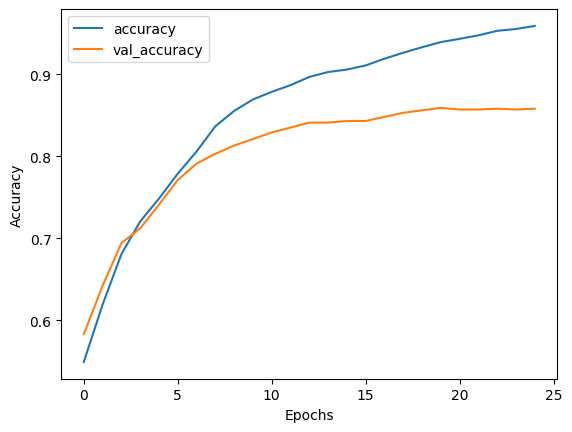

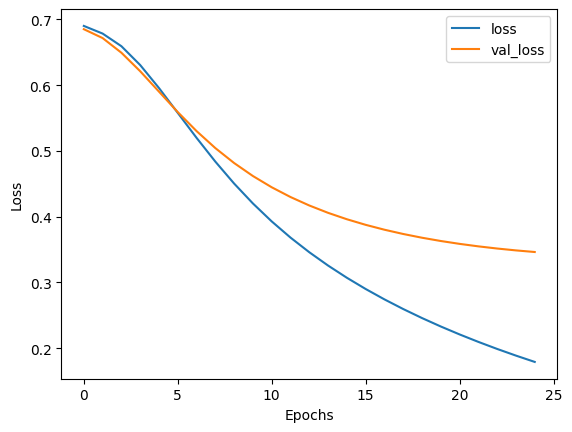

In [81]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f"val_{metric}"])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f"val_{metric}"])
    plt.show()


plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

## Export the model
In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [92]:
export_model = tf.keras.Sequential(
    [
        vectorize_layer,
        model,
        # layers.Activation("sigmoid")
    ]
)

In [93]:
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=["accuracy"],
)

In [94]:
loss, accuracy = export_model.evaluate(raw_test_set)
print(accuracy)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8424 - loss: 0.3693
0.840399980545044


In [95]:
examples = tf.constant(
    ["The movie was great!", "The movie was okay.", "The movie was terrible..."]
)

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


array([[0.58495474],
       [0.4336432 ],
       [0.34342393]], dtype=float32)

## Or

In [96]:
# A string input
inputs = keras.Input(shape=(1,), dtype="string")
# Turn strings into vocab indices
indices = vectorize_layer(inputs)
# Turn vocab indices into predictions
outputs = model(indices)

# Our end to end model
end_to_end_model = keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
end_to_end_model.evaluate(raw_test_set)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8378 - loss: 0.3749


[0.3682108521461487, 0.840399980545044]

In [97]:
end_to_end_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


array([[0.58495474],
       [0.4336432 ],
       [0.34342393]], dtype=float32)